First, let's import all the necessary dependencies.

In [1]:
import xarray as xr
from cartopy import crs
import display
import matplotlib.pyplot as plt

Let's define some configuration variables.

In [2]:
PROJECTION = crs.Miller()
AREA = {"latitude": slice(-5, 5), "longitude": slice(-120, -80)}
TIME_RANGE = ("1997-04", "1998-04")
DATASET_LOCATION = "s3://cmems-reanalysis/cmems_mod_glo_phy_my_0.083_P1D-m.zarr"

In the following lines we:
- establish a connection with the remote dataset
- show its metadata

It is worth noticing that, in the first operation, only the information necessary to gather the dataset's metadata (e.g. its sizes, dimensions, variables' type and attributes) is actually downloaded from its remote location to the local machine.

In [3]:
ds = xr.open_dataset(DATASET_LOCATION, chunks={}, engine="zarr").astype("float32")
ds

/tmp/ipykernel_6069/992704108.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_dataset(DATASET_LOCATION, chunks={}, engine="zarr").astype("float32")


<xarray.Dataset>
Dimensions:    (time: 10227, latitude: 2041, longitude: 4320, depth: 50)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-31T12:00:00
Data variables:
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-01-06 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

Here we want to compute the average anomaly of the Sea Surface Height over a region of the Pacific Ocean during the 1997-1998 El Nino event, with respect to the whole time range available.

Note that the operations prescribed in the following lines are actually performed, and the resulting data downloaded, only when the `.compute()` method is met. For this reason, as a general rule to maximize efficiency, the `compute()` method should be placed after an operation which significantly reduce the amount of data, such as after selection and reduction operations.

In [4]:
%%time

zos = ds.zos
zos_area = zos.sel(**AREA)
zos_mean = zos_area.mean(dim="time")
zos_mean

CPU times: user 6.67 ms, sys: 3.67 ms, total: 10.3 ms
Wall time: 9.72 ms


<xarray.DataArray 'zos' (latitude: 121, longitude: 481)>
dask.array<mean_agg-aggregate, shape=(121, 481), dtype=float32, chunksize=(121, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -5.0 -4.917 -4.833 -4.75 ... 4.833 4.917 5.0
  * longitude  (longitude) float32 -120.0 -119.9 -119.8 ... -80.17 -80.08 -80.0
Attributes:
    _ChunkSizes:               [1, 681, 1440]
    cell_methods:              area: mean
    last_restart_dim_updated:  10227
    long_name:                 Sea surface height
    standard_name:             sea_surface_height_above_geoid
    unit_long:                 Meters
    units:                     m
    valid_max:                 5039
    valid_min:                 -6181

In [5]:
zos_mean = zos_mean.compute()
zos_anomaly = zos_area - zos_mean
zos_anomaly_event = zos_anomaly.sel(time=slice(TIME_RANGE[0], TIME_RANGE[1]))
zos_anomaly_event_mean = zos_anomaly_event.mean(dim="time")

Let's plot the results on map.

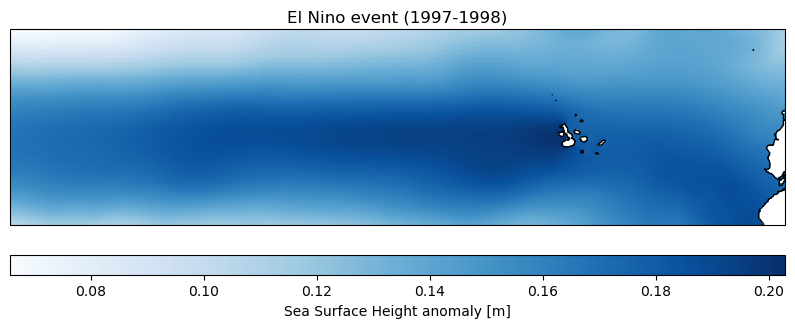

In [6]:
_, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={"projection": PROJECTION},
)
zos_anomaly_event_mean.plot(
    ax=ax, 
    cmap="Blues", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Sea Surface Height anomaly [m]"},
)
ax.coastlines()
ax.set_title("El Nino event (1997-1998)")
plt.show()

Finally, we want to compute the average monthly Surface Height anomaly for all the covered time-range, in order to highlight all occurred El Nino events.

The same considerations done before apply here.

In [7]:
zos = ds.zos
zos_area = zos.sel(**AREA)
zos_monthly = zos_area.resample(time="1M").mean()
zos_monthly_spatial_mean = zos_monthly.mean(dim=["latitude", "longitude"])
zos_monthly_spatial_mean

<xarray.DataArray 'zos' (time: 336)>
dask.array<mean_agg-aggregate, shape=(336,), dtype=float32, chunksize=(7,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2020-12-31
Attributes:
    _ChunkSizes:               [1, 681, 1440]
    cell_methods:              area: mean
    last_restart_dim_updated:  10227
    long_name:                 Sea surface height
    standard_name:             sea_surface_height_above_geoid
    unit_long:                 Meters
    units:                     m
    valid_max:                 5039
    valid_min:                 -6181

In [ ]:
%%time

zos_monthly_spatial_mean = zos_monthly_spatial_mean.compute()
zos_mean = zos_monthly_spatial_mean.mean()
zos_anomaly = (zos_monthly_spatial_mean - zos_mean)

Let's plot the results as a time series.

In [ ]:
plt.plot(zos_anomaly['time'], zos_anomaly)
plt.xlabel('Year')
plt.ylabel('Sea Surface Height anomaly [m]')
plt.xticks(rotation=45)
plt.show()